In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import tensorflow as tf
from cache import Cache

C:\Users\Sukhada\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

In [3]:
tf.keras.__version__

'2.1.6-tf'

In [4]:
import coco

In [5]:
import nltk

In [ ]:
 nltk.download()

In [6]:
import json
import os

In [7]:
data_dir = "D:\WCE\BTech-1\my\Project\Dataset\coco"

train_dir = "D:\WCE\BTech-1\my\Project\Dataset\coco\train\train2014"
val_dir = "D:\WCE\BTech-1\my\Project\Dataset\coco\val\val2014"
data_url = "http://images.cocodataset.org/"

In [8]:
# helper function to load the data

def _load_records(train=True):
    """
    Load the image-filenames and captions
    for either the training-set or the validation-set.
    """

    if train:
        # Training-set.
        filename = "captions_train2014.json"
    else:
        # Validation-set.
        filename = "captions_val2014.json"

    # Full path for the data-file.
    path = os.path.join(data_dir, "annotations", filename)

    # Load the file.
    with open(path, "r", encoding="utf-8") as file:
        data_raw = json.load(file)

    # Convenience variables.
    images = data_raw['images']
    annotations = data_raw['annotations']

    # The lookup-key is the image-id.
    records = dict()

    # Collect all the filenames for the images.
    for image in images:
        # Get the id and filename for this image.
        image_id = image['id']
        filename = image['file_name']

        # Initialize a new data-record.
        record = dict()

        # Set the image-filename in the data-record.
        record['filename'] = filename

        # Initialize an empty list of image-captions
        record['captions'] = list()

        # Save the record using the the image-id as the lookup-key.
        records[image_id] = record

    # Collect all the captions for the images.
    for ann in annotations:
        # Get the id and caption for an image.
        image_id = ann['image_id']
        caption = ann['caption']

        # Lookup the data-record for this image-id.
        record = records[image_id]

        # Append the current caption to the list of captions in the
        record['captions'].append(caption)

    # Convert the records-dict to a list of tuples.
    records_list = [(key, record['filename'], record['captions'])
                    for key, record in sorted(records.items())]

    # Convert the list of tuples to separate tuples with the data.
    ids, filenames, captions = zip(*records_list)
    print(type(filenames))
    return ids, filenames, captions



In [9]:
#loading training data
id, filenm, captions = _load_records(train_dir)


<class 'tuple'>


In [10]:
#combining in one dataframe
import pandas as pd
input_data = {'id': id, 'filename': filenm, 'captions' :captions}
input_data = pd.DataFrame(data=input_data)
input_data

,id,filename,captions
0,9,COCO_train2014_000000000009.jpg,[Closeup of bins of food that include broccoli...
1,25,COCO_train2014_000000000025.jpg,[A giraffe eating food from the top of the tre...
2,30,COCO_train2014_000000000030.jpg,"[A flower vase is sitting on a porch stand., W..."
3,34,COCO_train2014_000000000034.jpg,[A zebra grazing on lush green grass in a fiel...
4,36,COCO_train2014_000000000036.jpg,[Woman in swim suit holding parasol on sunny d...
5,49,COCO_train2014_000000000049.jpg,[A couple of men riding horses on top of a gre...
6,61,COCO_train2014_000000000061.jpg,[They are brave for riding in the jungle on th...
7,64,COCO_train2014_000000000064.jpg,[a black and silver clock tower at an intersec...
8,71,COCO_train2014_000000000071.jpg,[A train coming to a stop on the tracks out si...
9,72,COCO_train2014_000000000072.jpg,[A couple of giraffe snuggling each other in a...


In [11]:
#image loading
def load_image(path, size=None):
    
    img = Image.open(path)

    if not size is None:
        img = img.resize(size=size, resample=Image.LANCZOS)

    # Convert image to numpy array.
    img = np.array(img)

    # Scale image-pixels so they fall between 0.0 and 1.0
    img = img / 255.0
    
    # grayscale to rgb
    if (len(img.shape) == 2):
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)

    return img

In [12]:
#showing image
def show_image(index, train):
    
    if train:
        # Use an image from the training-set.
        dir = 'D:/WCE/BTech-1/my/Project/Dataset/coco/train/train2014'
        filename = input_data.filename[index]
        captions = input_data.captions[index]
    else:
        # Use an image from the validation-set.
        dir = 'D:/WCE/BTech-1/my/Project/Dataset/coco/val/val2014'
        filename = val_data.filename[index]
        captions = val_data.captions[index]

    # Path for the image-file.
    path = os.path.join(dir, filename)
    
    # Load the image and plot it.
    img = load_image(path)
    plt.imshow(img)
    plt.show()
    
     # Print the captions for this image.
    for caption in captions:
        print(caption)

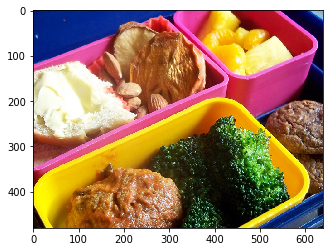

Closeup of bins of food that include broccoli and bread.
A meal is presented in brightly colored plastic trays.
there are containers filled with different kinds of foods
Colorful dishes holding meat, vegetables, fruit, and bread.
A bunch of trays that have different food.


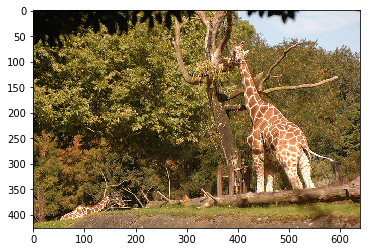

A giraffe eating food from the top of the tree.
A giraffe standing up nearby a tree 
A giraffe mother with its baby in the forest.
Two giraffes standing in a tree filled area.
A giraffe standing next to a forest filled with trees.


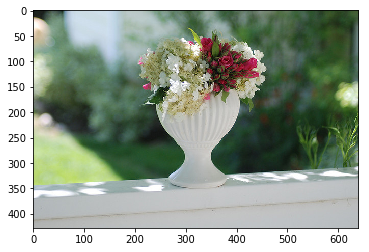

A flower vase is sitting on a porch stand.
White vase with different colored flowers sitting inside of it. 
a white vase with many flowers on a stage
A white vase filled with different colored flowers.
A vase with red and white flowers outside on a sunny day.


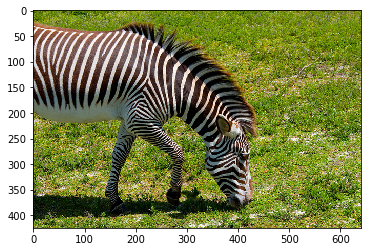

A zebra grazing on lush green grass in a field.
Zebra reaching its head down to ground where grass is. 
The zebra is eating grass in the sun.
A lone zebra grazing in some green grass.
a Zebra grazing on grass in a green open field.


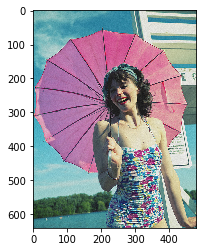

Woman in swim suit holding parasol on sunny day.
A woman posing for the camera, holding a pink, open umbrella and wearing a bright, floral, ruched bathing suit, by a life guard stand with lake, green trees, and a blue sky with a few clouds behind.
A woman in a floral swimsuit holds a pink umbrella.
A woman with an umbrella near the sea
A girl in a bathing suit with a pink umbrella.


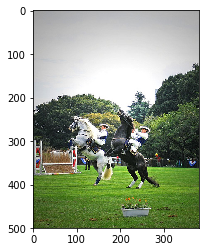

A couple of men riding horses on top of a green field.
two horses and their riders on some grass
Two men are on horses that are reared back.
A pair of horses performing tricks in a field. 
Two costumed horse riders make their horses stand on their hind legs.


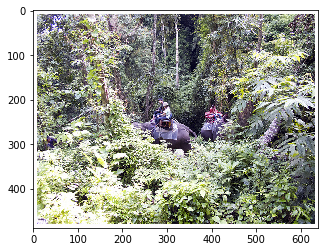

They are brave for riding in the jungle on those elephants.
SOME PEOPLE IN THE WOODS RIDING TWO ELEPHANTS
Some people who are riding on top of elephants.
there are people riding elephants in the middle of a forest
Several elephants in the jungle carrying people on their backs


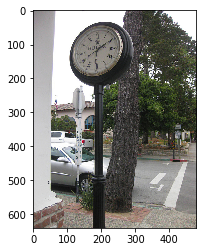

a black and silver clock tower at an intersection near a tree
A clock sits on top of a black pole near a tree on a sidewalk near a crosswalk.
A pole with a clock that reads 6:10 by a white car. 
A clock is seen in front of a tall tree.
A very pretty clock on the side of a road.


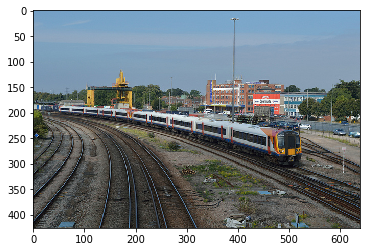

A train coming to a stop on the tracks out side.
The very long train is travelling down the tracks.
A passenger train glides around a curve on the outer track.
A train coming down the tracks in the city.
A train engine carrying many carts down a track.


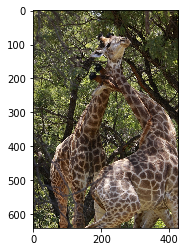

A couple of giraffe snuggling each other in a forest.
A couple of giraffe standing next to some trees.
Two Zebras seem to be embracing in the wild. 
Two giraffes hang out near trees and nuzzle up to each other.
The two giraffes appear to be hugging each other.


In [13]:
for i in range(0,10):
    show_image(index=input_data.index[i], train=True)

In [14]:
# transfer learning for representing images
# use of VGG16 model






In [15]:
image_model = VGG16(include_top=True, weights='imagenet')

In [16]:
image_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [17]:
transfer_layer = image_model.get_layer('fc2')

In [18]:
image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

In [19]:
img_size = K.int_shape(image_model.input)[1:3]
img_size

(224, 224)

In [20]:
transfer_values_size = K.int_shape(transfer_layer.output)[1]
transfer_values_size

4096

In [60]:
#function to pass the batch of image to form a representation
def process_images(data_dir, filenames, batch_size=32):
    num_images = len(filenames)

    # Pre-allocate input-batch-array for images.
    shape = (batch_size,) + img_size + (3,)
    image_batch = np.zeros(shape=shape, dtype=np.float16)

    # Pre-allocate output-array for transfer-values.
    shape = (num_images, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    # Initialize index into the filenames.
    start_index = 0

    # Process batches of image-files.
    while start_index < num_images:
        
        end_index = start_index + batch_size

        # Ensure end-index is within bounds.
        if end_index > num_images:
            end_index = num_images

        # The last batch may have a different batch-size.
        current_batch_size = end_index - start_index

        # Load all the images in the batch.
        for i, filename in enumerate(filenames[start_index:end_index]):
            # Path for the image-file.
            path = os.path.join(data_dir, filename)

            img = load_image(path, size=img_size)

            # Save the image for later use.
            image_batch[i] = img

        transfer_values_batch = \
            image_model_transfer.predict(image_batch[0:current_batch_size])

        # Save the transfer-values in the pre-allocated array.
        transfer_values[start_index:end_index] = \
            transfer_values_batch[0:current_batch_size]

        # Increase the index for the next loop-iteration.
        start_index = end_index

    
    print()

    return transfer_values

In [65]:
#extracting cached values of transfer layer 
import pickle
def process_images_train():
    # Path for the cache-file.
    cache_path = os.path.join("D:/WCE/BTech-1/my/Project/Dataset/coco/train/train2014",
                              "transfer_values_train.pkl")
    file = open(cache_path,'wb')
    # If the cache-file already exists then reload it,
    # otherwise process all images and save their transfer-values
    # to the cache-file so it can be reloaded quickly.
    if(os.stat(cache_path).st_size == 0):
        
        transfer_values = process_images("D:/WCE/BTech-1/my/Project/Dataset/coco/train/train2014", filenm[0:128],32)
        pickle.dump(transfer_values, file)
        print("hi")
    file.close()
        
    file = open(cache_path, 'rb')
    transfer_values = pickle.load(file)
        
    return transfer_values

In [66]:
%%time
transfer_values_train = process_images_train()


hi
Wall time: 1min 27s


In [67]:
print(transfer_values_train.shape)
print(transfer_values_train)

(128, 4096)
[[0.      0.      1.378   ... 0.      0.      0.5244 ]
 [0.      0.      1.268   ... 0.      0.      0.461  ]
 [0.      0.      1.617   ... 0.      0.      0.533  ]
 ...
 [0.      0.      1.123   ... 0.      0.      1.013  ]
 [0.      0.10754 1.34    ... 0.      0.      1.142  ]
 [0.      0.      1.142   ... 0.      0.      0.832  ]]
